<a href="https://colab.research.google.com/github/PolianaQueiroz/Master-Research-Lab/blob/main/AjustePSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyswarms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.9 MB/s eta 0:00:00


2025-08-29 11:57:29,765 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.8}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=2.49e-5
2025-08-29 11:57:30,255 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.4871186659128844e-05, best pos: [2.09573396e-02 1.46738839e-02 2.89137900e+03]


Parâmetros verdadeiros: R0=0.02, R1=0.015, C1=2000
Parâmetros estimados : R0=0.02096, R1=0.01467, C1=2891.4


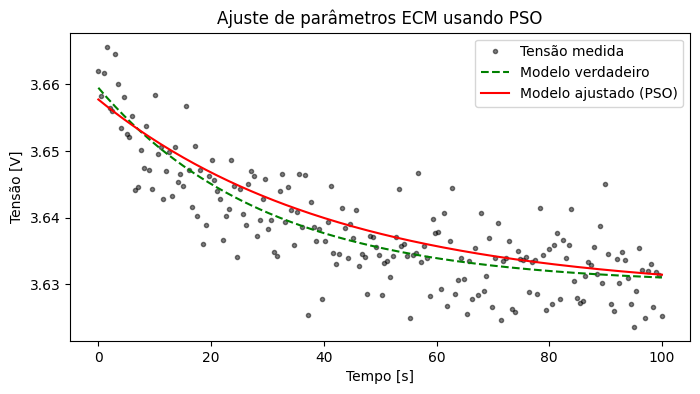

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyswarms.single import GlobalBestPSO

# 1. Criar dados simulados (corrente e tensão)
np.random.seed(42)
t = np.linspace(0, 100, 200)  # 200 amostras em 100s
I = 2.0 * np.ones_like(t)     # corrente constante 2A

# Parâmetros reais do modelo (que queremos recuperar)
R0_true, R1_true, C1_true = 0.02, 0.015, 2000

def ecm_model(I, t, R0, R1, C1, OCV=3.7):
    """Simula a tensão do modelo Thevenin 1RC."""
    dt = t[1] - t[0]
    V_RC = 0
    V = []
    for i in range(len(t)):
        dV_RC = (-V_RC / (R1*C1) + I[i]/C1) * dt
        V_RC += dV_RC
        Vt = OCV - I[i]*R0 - V_RC
        V.append(Vt)
    return np.array(V)

# Gerar dados de referência + ruído
V_true = ecm_model(I, t, R0_true, R1_true, C1_true)
V_meas = V_true + 0.005*np.random.randn(len(t))  # tensão medida com ruído

# 2. Função de custo para o PSO
def objective(params):
    errors = []
    for R0, R1, C1 in params:
        V_pred = ecm_model(I, t, R0, R1, C1)
        mse = np.mean((V_meas - V_pred)**2)
        errors.append(mse)
    return np.array(errors)

# 3. Configuração do PSO
options = {'c1': 1.5, 'c2': 1.5, 'w': 0.8}
optimizer = GlobalBestPSO(n_particles=20, dimensions=3,
                          options=options,
                          bounds=( [0.001, 0.001, 100], [0.1, 0.1, 5000] ))

# 4. Rodar otimização
cost, best_params = optimizer.optimize(objective, iters=50)
R0_est, R1_est, C1_est = best_params

print(f"Parâmetros verdadeiros: R0={R0_true}, R1={R1_true}, C1={C1_true}")
print(f"Parâmetros estimados : R0={R0_est:.5f}, R1={R1_est:.5f}, C1={C1_est:.1f}")

# 5. Comparar curvas
V_est = ecm_model(I, t, R0_est, R1_est, C1_est)

plt.figure(figsize=(8,4))
plt.plot(t, V_meas, 'k.', alpha=0.5, label="Tensão medida")
plt.plot(t, V_true, 'g--', label="Modelo verdadeiro")
plt.plot(t, V_est, 'r-', label="Modelo ajustado (PSO)")
plt.xlabel("Tempo [s]")
plt.ylabel("Tensão [V]")
plt.legend()
plt.title("Ajuste de parâmetros ECM usando PSO")
plt.show()
